# Recognition   

In [7]:
%load_ext autoreload
%autoreload 2
import os
import glob
import random
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from torchvision import transforms
from models.detection import Model, ModelTrainer, CustomDataset, Inference

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def prepare_dataloaders(data_dirs, batch_size=32, valid_split=0.1, test_split=0.1):
    all_images = []
    for data_dir in data_dirs:
        all_images += glob.glob(os.path.join(data_dir, 'imgs_and_labels', 'images', '*.jpg'))

    # Filter images to include only those that have corresponding labels
    all_images = [img for img in all_images if os.path.exists(img.replace('images', 'labels').replace('.jpg', '.txt'))]

    print(f"Total images after filtering: {len(all_images)}")
    
    random.shuffle(all_images)
    total_images = len(all_images)
    test_size = int(total_images * test_split)
    valid_size = int(total_images * valid_split)
    train_size = total_images - test_size - valid_size

    train_images = all_images[:train_size]
    valid_images = all_images[train_size:train_size + valid_size]
    test_images = all_images[train_size + valid_size:]

    print(f"Training images: {len(train_images)}")
    print(f"Validation images: {len(valid_images)}")
    print(f"Test images: {len(test_images)}")

    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor()
    ])

    train_dataset = CustomDataset(train_images, transform=transform)
    valid_dataset = CustomDataset(valid_images, transform=transform)
    test_dataset = CustomDataset(test_images, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, valid_loader, test_loader

In [3]:
# Define the data directories
data_dirs = [
    'data/real_1geo_bright_512867',
    'data/real_1geo_onlyflash_512875',
    'data/real_2geos_bright_512830',
    'data/real_2geos_onlyflash_512887',
    'data/real_3geos_bright_512712',
    'data/real_4geos_bright_512639',
    'data/real_4geos_onlyflash_512894'
]

In [8]:
# Prepare DataLoaders
train_loader, valid_loader, test_loader = prepare_dataloaders(data_dirs, batch_size=32)

# Debugging: Print a few batches from the train_loader to check the data
for images, labels in train_loader:
    print("Batch of images:", images.shape)
    print("Batch of labels:", labels)
    # Print example of unpacked labels
    for label in labels:
        print("Label:", label)
    break  # Print only the first batch


Total images after filtering: 1000
Training images: 800
Validation images: 100
Test images: 100
Initialized dataset with 800 images
Initialized dataset with 100 images
Initialized dataset with 100 images
Batch of images: torch.Size([32, 3, 128, 128])
Batch of labels: [tensor([0, 0, 3, 2, 0, 0, 3, 0, 0, 0, 1, 3, 2, 1, 3, 3, 2, 0, 0, 0, 0, 2, 3, 0,
        1, 0, 1, 3, 3, 3, 3, 3]), tensor([[0.2496, 0.1605, 0.3869, 0.3210],
        [0.6398, 0.5468, 0.7204, 0.9064],
        [0.3899, 0.4919, 0.3403, 0.3576],
        [0.3113, 0.3721, 0.3960, 0.5259],
        [0.3343, 0.7337, 0.2799, 0.3606],
        [0.7234, 0.3942, 0.3629, 0.4328],
        [0.8605, 0.5851, 0.2791, 0.4101],
        [0.4862, 0.5494, 0.4470, 0.6361],
        [0.2595, 0.1934, 0.3803, 0.3867],
        [0.4712, 0.4438, 0.3651, 0.4117],
        [0.1893, 0.4874, 0.3539, 0.3967],
        [0.5557, 0.4505, 0.3268, 0.3531],
        [0.5167, 0.7087, 0.8415, 0.5826],
        [0.5839, 0.5700, 0.3606, 0.4838],
        [0.3235, 0.5370, 0.64

In [9]:
model = Model(num_channels=3, num_classes=4)
trainer = ModelTrainer(model, train_loader, val_loader=valid_loader)
trainer.train(num_epochs=2)

Epoch 1/2, Train Loss: 1.4129, Val Loss: 1.3451, Val Accuracy: 28.00%
Epoch 2/2, Train Loss: 1.3176, Val Loss: 1.3387, Val Accuracy: 30.00%


Predictions shape: torch.Size([1, 4])
Predictions: tensor([[ 1.2562, -1.0004,  0.1749,  0.4662]])
Labels: tensor(0)
True boxes: tensor([0.7519, 0.5685, 0.3539, 0.3726])
Predicted boxes: [ 1.2561779  -1.0004289   0.1749475   0.46622783]


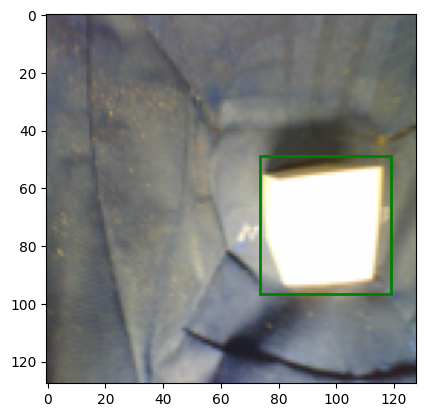

In [12]:
inference = Inference(model, test_loader)
inference.run_inference()